# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем данные из соревнования [House Prices: Advanced Regression Techniques.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [2]:
# Будем использовать только обучающую выборку
data = pd.read_csv('imdb.csv', sep=';')

In [3]:
# размер набора данных
data.shape

(1000, 8)

In [4]:
# типы колонок
data.dtypes

title            object
director         object
release_year     object
runtime         float64
genre            object
rating          float64
metascore       float64
gross           float64
dtype: object

In [5]:
# проверим есть ли пропущенные значения
data.isnull().sum()

title             5
director          7
release_year      6
runtime           5
genre             5
rating            4
metascore       156
gross           188
dtype: int64

In [6]:
# Первые 5 строк датасета
data.head()

,title,director,release_year,runtime,genre,rating,metascore,gross
0,The Shawshank Redemption,Frank Darabont,1994,142.0,Drama,9.3,82.0,28.34
1,The Godfather,Francis Ford Coppola,1972,175.0,"Crime, Drama",9.2,100.0,134.97
2,The Dark Knight,Christopher Nolan,2008,152.0,"Action, Crime, Drama",9.0,84.0,534.86
3,Schindler's List,Steven Spielberg,1993,195.0,"Biography, Drama, History",9.0,95.0,96.90
4,12 Angry Men,Sidney Lumet,1957,96.0,"Crime, Drama",9.0,97.0,4.36


In [7]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 1000


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [8]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((1000, 8), (1000, 0))

In [9]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((1000, 8), (717, 8))

In [10]:
data.head()

,title,director,release_year,runtime,genre,rating,metascore,gross
0,The Shawshank Redemption,Frank Darabont,1994,142.0,Drama,9.3,82.0,28.34
1,The Godfather,Francis Ford Coppola,1972,175.0,"Crime, Drama",9.2,100.0,134.97
2,The Dark Knight,Christopher Nolan,2008,152.0,"Action, Crime, Drama",9.0,84.0,534.86
3,Schindler's List,Steven Spielberg,1993,195.0,"Biography, Drama, History",9.0,95.0,96.90
4,12 Angry Men,Sidney Lumet,1957,96.0,"Crime, Drama",9.0,97.0,4.36


In [11]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,title,director,release_year,runtime,genre,rating,metascore,gross
0,The Shawshank Redemption,Frank Darabont,1994,142.0,Drama,9.3,82.0,28.34
1,The Godfather,Francis Ford Coppola,1972,175.0,"Crime, Drama",9.2,100.0,134.97
2,The Dark Knight,Christopher Nolan,2008,152.0,"Action, Crime, Drama",9.0,84.0,534.86
3,Schindler's List,Steven Spielberg,1993,195.0,"Biography, Drama, History",9.0,95.0,96.90
4,12 Angry Men,Sidney Lumet,1957,96.0,"Crime, Drama",9.0,97.0,4.36


## "Внедрение значений" - импьютация (imputation)

### Обработка пропусков в числовых данных

In [12]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка runtime. Тип данных float64. Количество пустых значений 5, 0.5%.
Колонка rating. Тип данных float64. Количество пустых значений 4, 0.4%.
Колонка metascore. Тип данных float64. Количество пустых значений 156, 15.6%.
Колонка gross. Тип данных float64. Количество пустых значений 188, 18.8%.


In [13]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,runtime,rating,metascore,gross
0,142.0,9.3,82.0,28.34
1,175.0,9.2,100.0,134.97
2,152.0,9.0,84.0,534.86
3,195.0,9.0,95.0,96.90
4,96.0,9.0,97.0,4.36
...,...,...,...,...
995,133.0,7.6,76.0,6.17
996,105.0,7.6,87.0,35.81
997,98.0,7.6,77.0,37.71
998,71.0,7.6,87.0,NaN


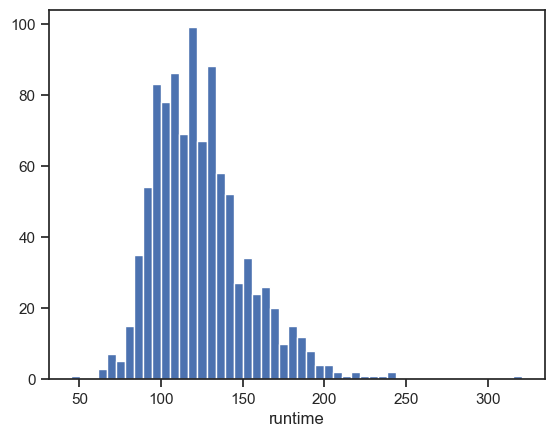

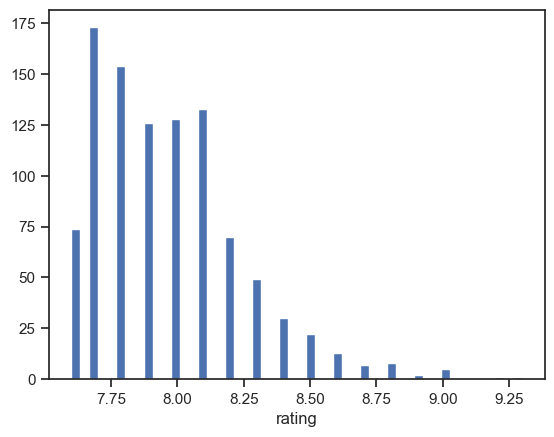

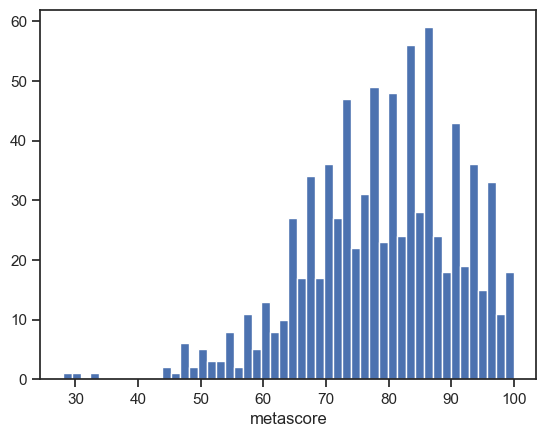

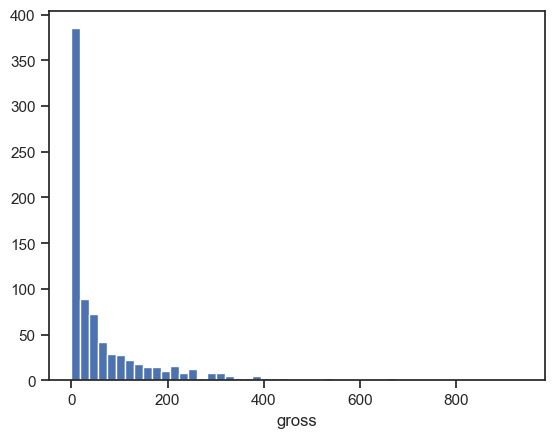

In [14]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

In [15]:
data_num_MasVnrArea = data_num[['metascore']]
data_num_MasVnrArea.head()

,metascore
0,82.0
1,100.0
2,84.0
3,95.0
4,97.0


In [16]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [17]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_MasVnrArea)
mask_missing_values_only

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [18]:
strategies=['mean', 'median', 'most_frequent']

In [19]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_MasVnrArea)
    return data_num_imp[mask_missing_values_only]

In [20]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274882, 78.97274882, 78.97274882,
        78.97274882, 78.97274882, 78.97274

In [21]:
strategies[1], test_num_impute(strategies[1])

('median',
 array([80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.,
        80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80., 80.]))

In [22]:
strategies[2], test_num_impute(strategies[2])

('most_frequent',
 array([86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.,
        86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86., 86.]))

In [23]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [24]:
data[['gross']].describe()

,gross
count,812.000000
mean,71.131404
std,117.171987
min,0.000000
25%,3.180000
50%,23.250000
75%,85.100000
max,936.660000


In [25]:
test_num_impute_col(data, 'gross', strategies[0])

('gross', 'mean', 188, 71.1314039408867, 71.1314039408867)

In [26]:
test_num_impute_col(data, 'gross', strategies[1])

('gross', 'median', 188, 23.25, 23.25)

In [27]:
test_num_impute_col(data, 'gross', strategies[2])

('gross', 'most_frequent', 188, 0.01, 0.01)

### Обработка пропусков в категориальных данных

In [28]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка title. Тип данных object. Количество пустых значений 5, 0.5%.
Колонка director. Тип данных object. Количество пустых значений 7, 0.7%.
Колонка release_year. Тип данных object. Количество пустых значений 6, 0.6%.
Колонка genre. Тип данных object. Количество пустых значений 5, 0.5%.


**Какие из этих колонок Вы бы выбрали или не выбрали для построения модели?**

Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [29]:
cat_temp_data = data[['release_year']]
cat_temp_data.head()

,release_year
0,1994
1,1972
2,2008
3,1993
4,1957


In [30]:
cat_temp_data['release_year'].unique()

array(['1994', '1972', '2008', '1993', '1957', '2003', '1974', '2023',
       '2010', '2001', '1999', '1966', '2002', '2021', '2022', '2014',
       '1990', '1975', '1980', '2020', '1991', '1995', '1998', '1977',
       '1997', '1954', '1946', '1962', '1985', '2006', '2000', '1979',
       '2019', '1942', '1960', '2011', '1968', '1988', nan, '1931',
       'II 2018', '1981', '2018', '2012', '1986', 'I 2019', '1984',
       'I 2017', '2016', '2009', '1964', '1950', '1940', '1963', '1987',
       '1983', '2004', '1971', '1958', '1992', '1959', '1941', '1952',
       '1927', '1973', '1961', '1944', '2007', '1948', '2017', '1921',
       '2013', '1989', '1982', '2005', '1976', 'I 2020', '1939', '1965',
       '2015', '1955', '1969', '1953', '1928', 'I 2015', '1996', '1978',
       'I 2013', '1967', '1949', '1934', '1951', '1926', '1925', '1937',
       'III 2016', 'I 2014', '1920', '1947', 'I 2004', '1945', 'II 2016',
       '1956', '1922', 'I 2011', '1933', '1970', '1938', 'I 2001',
     

In [31]:
cat_temp_data[cat_temp_data['release_year'].isnull()].shape

(6, 1)

In [32]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['1994'],
       ['1972'],
       ['2008'],
       ['1993'],
       ['1957'],
       ['2003'],
       ['1974'],
       ['2023'],
       ['1994'],
       ['2010'],
       ['2001'],
       ['1999'],
       ['1994'],
       ['1966'],
       ['2002'],
       ['2021'],
       ['2022'],
       ['2014'],
       ['1990'],
       ['1999'],
       ['1975'],
       ['1980'],
       ['2022'],
       ['2020'],
       ['1999'],
       ['1991'],
       ['1995'],
       ['1998'],
       ['1991'],
       ['1977'],
       ['2001'],
       ['2002'],
       ['1997'],
       ['1954'],
       ['1946'],
       ['1962'],
       ['2022'],
       ['1985'],
       ['2006'],
       ['2000'],
       ['1979'],
       ['2019'],
       ['2006'],
       ['2014'],
       ['1994'],
       ['1994'],
       ['1995'],
       ['1942'],
       ['1998'],
       ['1960'],
       ['2002'],
       ['2011'],
       ['1968'],
       ['1988'],
       ['1954'],
       ['1988'],
       ['2004'],
       ['1931'],
       ['II 20

In [33]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['1920', '1921', '1922', '1925', '1926', '1927', '1928', '1931',
       '1932', '1933', '1934', '1935', '1937', '1938', '1939', '1940',
       '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948',
       '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023', 'I 1985', 'I 1995', 'I 2001', 'I 2004',
       'I 2006', 'I 2007', 'I 2008', 'I 2010', 'I 2011', 'I 2013',
       'I 

In [34]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['1994'],
       ['1972'],
       ['2008'],
       ['1993'],
       ['1957'],
       ['2003'],
       ['1974'],
       ['2023'],
       ['1994'],
       ['2010'],
       ['2001'],
       ['1999'],
       ['1994'],
       ['1966'],
       ['2002'],
       ['2021'],
       ['2022'],
       ['2014'],
       ['1990'],
       ['1999'],
       ['1975'],
       ['1980'],
       ['2022'],
       ['2020'],
       ['1999'],
       ['1991'],
       ['1995'],
       ['1998'],
       ['1991'],
       ['1977'],
       ['2001'],
       ['2002'],
       ['1997'],
       ['1954'],
       ['1946'],
       ['1962'],
       ['2022'],
       ['1985'],
       ['2006'],
       ['2000'],
       ['1979'],
       ['2019'],
       ['2006'],
       ['2014'],
       ['1994'],
       ['1994'],
       ['1995'],
       ['1942'],
       ['1998'],
       ['1960'],
       ['2002'],
       ['2011'],
       ['1968'],
       ['1988'],
       ['1954'],
       ['1988'],
       ['NA'],
       ['1931'],
       ['II 2018

In [35]:
np.unique(data_imp3)

array(['1920', '1921', '1922', '1925', '1926', '1927', '1928', '1931',
       '1932', '1933', '1934', '1935', '1937', '1938', '1939', '1940',
       '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948',
       '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023', 'I 1985', 'I 1995', 'I 2001', 'I 2004',
       'I 2006', 'I 2007', 'I 2008', 'I 2010', 'I 2011', 'I 2013',
       'I 

In [36]:
data_imp3[data_imp3=='NA'].size

6

# Преобразование категориальных признаков в числовые

In [37]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,1994
1,1972
2,2008
3,1993
4,1957
...,...
995,2004
996,1996
997,2013
998,1933


## Кодирование категорий целочисленными значениями (label encoding)

В этом случае уникальные значения категориального признака кодируются целыми числами.

В scikit-learn для такого кодирования используется два класса :

- [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) - который ориентирован на применение к одному признаку. Этот класс прежде всего предназначен для кодирования целевого признака, но может быть также использован для последовательного кодирования отдельных нецелевых признаков.
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - который ориентирован на применение к матрице объект-признак, то есть для кодирования матрицы нецелевых признаков.

### Использование LabelEncoder

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
cat_enc['c1'].unique()

array(['1994', '1972', '2008', '1993', '1957', '2003', '1974', '2023',
       '2010', '2001', '1999', '1966', '2002', '2021', '2022', '2014',
       '1990', '1975', '1980', '2020', '1991', '1995', '1998', '1977',
       '1997', '1954', '1946', '1962', '1985', '2006', '2000', '1979',
       '2019', '1942', '1960', '2011', '1968', '1988', '2004', '1931',
       'II 2018', '1981', '2018', '2012', '1986', 'I 2019', '1984',
       'I 2017', '2016', '2009', '1964', '1950', '1940', '1963', '1987',
       '1983', '1971', '1958', '1992', '1959', '1941', '1952', '1927',
       '1973', '1961', '1944', '2007', '1948', '2017', '1921', '2013',
       '1989', '1982', '2005', '1976', 'I 2020', '1939', '1965', '2015',
       '1955', '1969', '1953', '1928', 'I 2015', '1996', '1978', 'I 2013',
       '1967', '1949', '1934', '1951', '1926', '1925', '1937', 'III 2016',
       'I 2014', '1920', '1947', 'I 2004', '1945', 'II 2016', '1956',
       '1922', 'I 2011', '1933', '1970', '1938', 'I 2001', 'I 2008',


In [40]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [41]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем 
# задачу классификации и каждое значение категории соответствует 
# какому-либо классу целевого признака

le.classes_

array(['1920', '1921', '1922', '1925', '1926', '1927', '1928', '1931',
       '1932', '1933', '1934', '1935', '1937', '1938', '1939', '1940',
       '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948',
       '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023', 'I 1985', 'I 1995', 'I 2001', 'I 2004',
       'I 2006', 'I 2007', 'I 2008', 'I 2010', 'I 2011', 'I 2013',
       'I 

In [42]:
cat_enc_le

array([ 69,  47,  83,  68,  32,  78,  49,  98,  69,  85,  76,  74,  69,
        41,  77,  96,  97,  89,  65,  74,  50,  55,  97,  95,  74,  66,
        70,  73,  66,  52,  76,  77,  72,  29,  21,  37,  97,  60,  81,
        75,  54,  94,  81,  89,  69,  69,  70,  17,  73,  35,  77,  86,
        43,  63,  29,  63,  79,   7, 116,  56,  93,  94,  87,  54,  61,
       113,  87,  93,  55,  78,  75,  59,  60, 112,  91,  83,  84,  81,
        39,  56,  93,  25,  32,  32,  15,  38,  94,  96,  94,  96,  97,
        70,  84,  62,  58,  74,  75,  72,  79,  46,  33,  70,  43,  67,
        59,  87,  70,  95,  84,  58,  76,  85,  37,  85,  72,  34,  37,
        16,  27,   5,  48,  86,   7,  35,  91,  27,  36,  97,  19,  82,
        23,  92,  97,  97,  94,   1,  96,  93,  88,  98,  64,  88,  96,
        82,  68,  85,  82,  57,  80,  51,  94,  70,  75,  79,  67,  73,
        93,  78,  72,  74,  78,  63,  76, 114,  79,  14,  49,  80,  81,
        38,  34,  50,  55,  95,  84,  40,  60,  94,  97,  29,  2

In [43]:
np.unique(cat_enc_le)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

In [44]:
# В этом примере видно, что перед кодированием 
# уникальные значения признака сортируются в лексикографиеском порядке
le.inverse_transform([0, 1, 2, 3])

array(['1920', '1921', '1922', '1925'], dtype=object)

### Использование OrdinalEncoder

In [45]:
from sklearn.preprocessing import OrdinalEncoder

In [46]:
data_oe = data[['title', 'director', 'genre']]
data_oe.head()

,title,director,genre
0,The Shawshank Redemption,Frank Darabont,Drama
1,The Godfather,Francis Ford Coppola,"Crime, Drama"
2,The Dark Knight,Christopher Nolan,"Action, Crime, Drama"
3,Schindler's List,Steven Spielberg,"Biography, Drama, History"
4,12 Angry Men,Sidney Lumet,"Crime, Drama"


In [47]:
imp4 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_oe_filled = imp4.fit_transform(data_oe)
data_oe_filled

array([['The Shawshank Redemption', 'Frank Darabont', 'Drama'],
       ['The Godfather', 'Francis Ford Coppola', 'Crime, Drama'],
       ['The Dark Knight', 'Christopher Nolan', 'Action, Crime, Drama'],
       ...,
       ['Philomena', 'Stephen Frears', 'Biography, Comedy, Drama'],
       ['The Invisible Man', 'James Whale', 'Horror, Sci-Fi'],
       ['Cell 211', 'Daniel Monzón', 'NA']], dtype=object)

In [48]:
oe = OrdinalEncoder()
cat_enc_oe = oe.fit_transform(data_oe_filled)
cat_enc_oe

array([[864., 141., 133.],
       [756., 139., 120.],
       [728.,  77.,  20.],
       ...,
       [546., 475.,  80.],
       [785., 210., 188.],
       [162.,  92., 193.]])

In [49]:
# Уникальные значения 1 признака
np.unique(cat_enc_oe[:, 0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [50]:
# Уникальные значения 2 признака
np.unique(cat_enc_oe[:, 1])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [51]:
# Уникальные значения 3 признака
np.unique(cat_enc_oe[:, 2])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [52]:
# Наименования категорий в соответствии с порядковыми номерами
oe.categories_

[array(['12 Angry Men', '12 Monkeys', '12 Years a Slave', '1917',
        '2001: A Space Odyssey', '21 Grams', '25th Hour', '3 Idiots',
        '3-Iron', '300', '3:10 to Yuma', '4 Months, 3 Weeks and 2 Days',
        '50/50', '500 Days of Summer', '777 Charlie', '8½', 'A Beautifuld',
        'A Bronx Tale', 'A Christmas Story', 'A Clockwork Orange',
        'A Few Good Men', 'A Fistful of Dollars', 'A Man Called Ove',
        'A Man for All Seasons', 'A Night at the Opera', 'A Prophet',
        'A Separation', 'A Silent Voice: The Movie', 'A Star Is Born',
        'A Streetcar Named Desire', 'A Taxi Driver',
        'A Very Long Engagement', 'A Wednesday',
        'A Woman Under the Influence', 'About Elly', 'About Time',
        'Ace in the Hole', "Adam's Apples", 'Adaptation.', 'After Hours',
        'After the Wedding', 'Aftersun', 'Aguirre, the Wrath of God',
        'Airlift', 'Airplane!', 'Akira', 'Aladdin', 'Alien', 'Aliens',
        'All About Eve', 'All About My Mother',
     

In [53]:
# Обратное преобразование
oe.inverse_transform(cat_enc_oe)

array([['The Shawshank Redemption', 'Frank Darabont', 'Drama'],
       ['The Godfather', 'Francis Ford Coppola', 'Crime, Drama'],
       ['The Dark Knight', 'Christopher Nolan', 'Action, Crime, Drama'],
       ...,
       ['Philomena', 'Stephen Frears', 'Biography, Comedy, Drama'],
       ['The Invisible Man', 'James Whale', 'Horror, Sci-Fi'],
       ['Cell 211', 'Daniel Monzón', 'NA']], dtype=object)

### Проблемы использования LabelEncoder и OrdinalEncoder

Необходимо отметить, что LabelEncoder и OrdinalEncoder могут использоваться только для категориальных признаков в номинальных шкалах (для которых отсутствует порядок), например города, страны, названия рек и т.д. 

Это связано с тем, что задать какой-либо порядок при кодировании с помощью LabelEncoder и OrdinalEncoder невозможно, они сортируют категории в лексикографическом порядке.

При этом кодирование целыми числами создает фиктивное отношение порядка (1 < 2 < 3 < ...) которого не было в исходных номинальных шкалах. Данное отношение порядка может негативно повлиять на построение модели машинного обучения.

### Кодирование шкал порядка

Библиотека scikit-learn не предоставляет готового решения для кодирования шкал порядка, но можно воспользоваться [функцией map для отдельных объектов Series.](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [54]:
# пример шкалы порядка 'small' < 'medium' < 'large'
sizes = ['small', 'medium', 'large', 'small', 'medium', 'large', 'small', 'medium', 'large']

In [55]:
pd_sizes = pd.DataFrame(data={'sizes':sizes})
pd_sizes

,sizes
0,small
1,medium
2,large
3,small
4,medium
5,large
6,small
7,medium
8,large


In [56]:
pd_sizes['sizes_codes'] = pd_sizes['sizes'].map({'small':1, 'medium':2, 'large':3})
pd_sizes

,sizes,sizes_codes
0,small,1
1,medium,2
2,large,3
3,small,1
4,medium,2
5,large,3
6,small,1
7,medium,2
8,large,3


In [57]:
pd_sizes['sizes_decoded'] = pd_sizes['sizes_codes'].map({1:'small', 2:'medium', 3:'large'})
pd_sizes

,sizes,sizes_codes,sizes_decoded
0,small,1,small
1,medium,2,medium
2,large,3,large
3,small,1,small
4,medium,2,medium
5,large,3,large
6,small,1,small
7,medium,2,medium
8,large,3,large


## Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

В этом случае каждое уникальное значение признака становится новым отдельным признаком.

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [60]:
cat_enc.shape

(1000, 1)

In [61]:
cat_enc_ohe.shape

(1000, 120)

In [62]:
cat_enc_ohe

<1000x120 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [63]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
cat_enc.head(10)

,c1
0,1994
1,1972
2,2008
3,1993
4,1957
5,2003
6,1974
7,2023
8,1994
9,2010


## [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [65]:
pd.get_dummies(cat_enc).head()

,c1_1920,c1_1921,c1_1922,c1_1925,c1_1926,c1_1927,c1_1928,c1_1931,c1_1932,c1_1933,...,c1_I 2015,c1_I 2016,c1_I 2017,c1_I 2019,c1_I 2020,c1_II 2016,c1_II 2018,c1_II 2022,c1_III 2016,c1_III 2018
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [66]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,release_year_1920,release_year_1921,release_year_1922,release_year_1925,release_year_1926,release_year_1927,release_year_1928,release_year_1931,release_year_1932,release_year_1933,...,release_year_I 2016,release_year_I 2017,release_year_I 2019,release_year_I 2020,release_year_II 2016,release_year_II 2018,release_year_II 2022,release_year_III 2016,release_year_III 2018,release_year_nan
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [67]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [68]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['rating']])

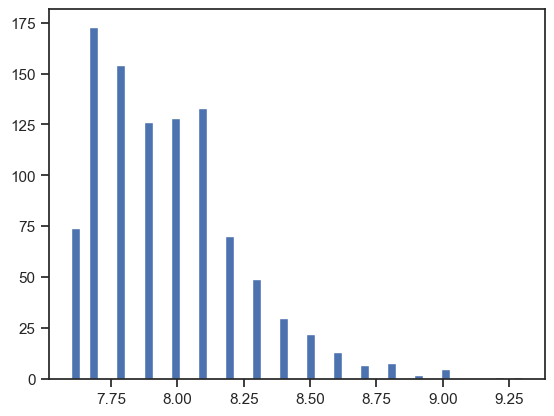

In [69]:
plt.hist(data['rating'], 50)
plt.show()

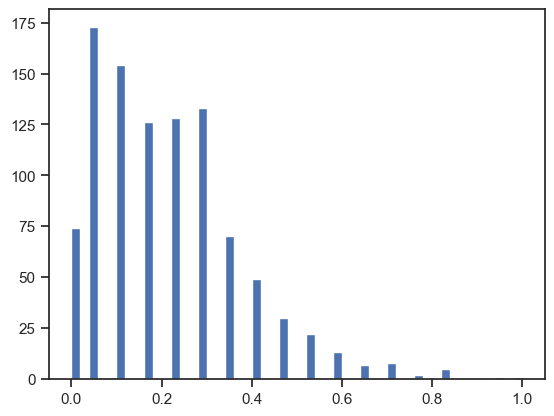

In [70]:
plt.hist(sc1_data, 50)
plt.show()

## Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [71]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['rating']])

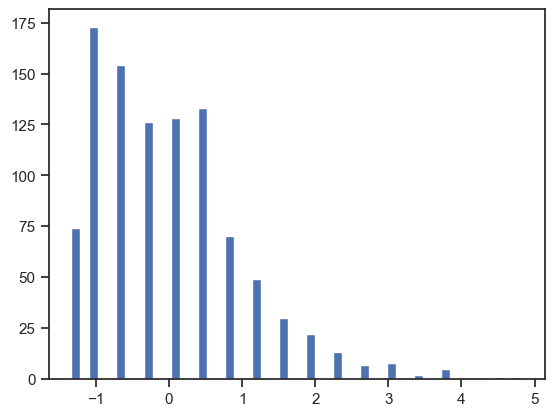

In [72]:
plt.hist(sc2_data, 50)
plt.show()

# Дополнительные источники
- [Руководство scikit-learn по предобработке данных](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Kaggle Data Cleaning Challenge: Handling missing values (упражнения с пояснениями по обработке пропущенных значений и масштабированию признаков)](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)
- [Краткое руководство по категориальным признакам](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)